In [1]:
import numpy as np
import pyedflib
import statistics
import plotly.graph_objects as go
import pandas as pd
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, ForgetDimension
from gtda.plotting import plot_point_cloud, plot_heatmap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, FastICA
from gtda.pipeline import Pipeline 


def read_edf_file(file_path):
    """
    Reads an .edf file and returns the EEG and EMG streams as pandas DataFrames.
    """
    f = pyedflib.EdfReader(file_path)

    # Assuming the EEG channel is the first channel and EMG is the second channel
    eeg_signal = f.readSignal(0)
    emg_signal = f.readSignal(1)

    # Extract the channel names for the DataFrame
    eeg_channel_name = f.getSignalLabels()[0]
    emg_channel_name = f.getSignalLabels()[1]

    # Get the sample frequency
    sample_frequency = f.getSampleFrequency(0)  # Assuming both streams have the same frequency

    # Calculate the timestamps for the samples
    n_samples = min(len(eeg_signal), len(emg_signal))
    time = [i / sample_frequency for i in range(n_samples)]

    # Create pandas DataFrame
    df = pd.DataFrame({
        'Time': time,
        eeg_channel_name: eeg_signal[:n_samples],
        emg_channel_name: emg_signal[:n_samples],
    })

    # Close the EdfReader
    f.close()

    return df

file = 'edf_293.edf'

data = read_edf_file(file)


x = data.Time
y = data.EEG

In [2]:
# Labels
label_df = pd.read_csv("Data_293.csv")
labels = label_df["NAPS_Numeric"].iloc[1:]
labels = [int(label) for label in labels]

# Label List

Label 1: W (Awake)

Label 2: WA (Awake Artifact)?

Label 3: NR (NREM)

Label 4: Not defined

Label 5: R (REM)

Label 7: U (Artifacts?)


# Local Approach

In [3]:
# How many segments per label do you want to analyze?
no_segments = 100

In [4]:
indices_dict = {}

for label in list(set(labels)): 
    indices = [index for index, value in enumerate(labels) if value == label][:no_segments]
    indices_dict[label] = indices

In [5]:
def segment_data(df, segment_size, step_size = 2):
    n_segments = int(df["Time"].iloc[-1]) // segment_size
    eeg_segments = []
    emg_segments = []

    for i in range(n_segments):
        start_idx = int(i* segment_size*1000/step_size)
        end_idx = start_idx + int(segment_size*1000/step_size)
        segment = df.iloc[start_idx:end_idx]
        eeg_segments.append(list(segment["EEG"]))
        emg_segments.append(list(segment["EMG"]))

    return eeg_segments, emg_segments

In [6]:
# Segment the data
segment_length = 4  # seconds
eeg_segments, emg_segments = segment_data(data, segment_length, step_size = 2)

## Finding the optimal embedding dimension and time delay

There are two techniques that can be used to determine these parameters automatically:
- Mutual information to determine the time delay
- False nearest neighbours to determine the embedding dimension

In [7]:
# Initialise the embedding

max_embedding_dimension = 30
max_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)

In [8]:
def fit_embedder(embedder: SingleTakensEmbedding, y: np.ndarray, verbose: bool=True) -> np.ndarray:
    """Fits a Takens embedder and displays optimal search parameters."""
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(
            f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}"
        )

    return y_embedded

In [9]:
# Look at some random segments
y_embedded = fit_embedder(embedder, eeg_segments[0])
y_embedded = fit_embedder(embedder, eeg_segments[100])
y_embedded = fit_embedder(embedder, eeg_segments[177])
y_embedded = fit_embedder(embedder, eeg_segments[1000])
# The optimal values are all similar (=> Just use embedding dimension 5 and time delay 25)

Shape of embedded time series: (380, 5)
Optimal embedding dimension is 5 and time delay is 26
Shape of embedded time series: (383, 4)
Optimal embedding dimension is 4 and time delay is 29
Shape of embedded time series: (383, 5)
Optimal embedding dimension is 5 and time delay is 22
Shape of embedded time series: (373, 6)
Optimal embedding dimension is 6 and time delay is 27


## Creating Persistence Diagrams

In [10]:
# Setting parameters for point cloud embeddings

embedding_dimension= 5
embedding_time_delay = 25
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

In [11]:
# We will look at 0, 1 and 2 dimensional holes TODO try more?
homology_dimensions = [0, 1, 2]

# We will use a Vietoris Rips filtrations
persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)

### Computing Points Clouds and Persistence Diagrams

In [12]:
# Label 1

# Point cloud embeddings
y_embedded1 = {} 

# Persistence diagrams
diagrams1 = {}

# Loop through the first segments with label '1'
for label_idx in indices_dict[1]:
    y_embedded1[label_idx] = embedder_periodic.fit_transform(eeg_segments[label_idx])[None, :, :]
    diagrams1[label_idx] = persistence.fit_transform(y_embedded1[label_idx])

In [13]:
# Label 3

# Point cloud embeddings
y_embedded3 = {} 

# Persistence diagrams
diagrams3 = {}

# Loop through the first segments with label '3'
for label_idx in indices_dict[3]:
    y_embedded3[label_idx] = embedder_periodic.fit_transform(eeg_segments[label_idx])[None, :, :]
    diagrams3[label_idx] = persistence.fit_transform(y_embedded3[label_idx])

In [14]:
# Label 5

# Point cloud embeddings
y_embedded5 = {} 

# Persistence diagrams
diagrams5 = {}

# Loop through the first segments with label '5'
for label_idx in indices_dict[5]:
    y_embedded5[label_idx] = embedder_periodic.fit_transform(eeg_segments[label_idx])[None, :, :]
    diagrams5[label_idx] = persistence.fit_transform(y_embedded5[label_idx])

In [15]:
# Label 7

# Point cloud embeddings
y_embedded7 = {} 

# Persistence diagrams
diagrams7 = {}

# Loop through the first segments with label '1'
for label_idx in indices_dict[7]:
    y_embedded7[label_idx] = embedder_periodic.fit_transform(eeg_segments[label_idx])[None, :, :]
    diagrams7[label_idx] = persistence.fit_transform(y_embedded7[label_idx])

## Computing And Plotting Features

### Get Features from Persistence Diagrams

In [16]:
# These are the features that we will examine for the persistence diagrams of each label
PE = PersistenceEntropy()
AM = Amplitude()
NP = NumberOfPoints()
CP = ComplexPolynomial()

In [17]:
persistence_entropy1 = {}
amplitude1 = {}
no_points1 = {}
complex_polynomial1 = {}

for label_idx in indices_dict[1]:
    persistence_entropy1[label_idx] = PE.fit_transform(diagrams1[label_idx])
    amplitude1[label_idx] = AM.fit_transform(diagrams1[label_idx])
    no_points1[label_idx] = NP.fit_transform(diagrams1[label_idx])
    complex_polynomial1[label_idx] = CP.fit_transform(diagrams1[label_idx])

In [18]:
persistence_entropy3 = {}
amplitude3 = {}
no_points3 = {}
complex_polynomial3 = {}


for label_idx in indices_dict[3]:
    persistence_entropy3[label_idx] = PE.fit_transform(diagrams3[label_idx])
    amplitude3[label_idx] = AM.fit_transform(diagrams3[label_idx])
    no_points3[label_idx] = NP.fit_transform(diagrams3[label_idx])
    complex_polynomial3[label_idx] = CP.fit_transform(diagrams3[label_idx])

In [19]:
persistence_entropy5 = {}
amplitude5 = {}
no_points5 = {}
complex_polynomial5 = {}


for label_idx in indices_dict[5]:
    persistence_entropy5[label_idx] = PE.fit_transform(diagrams5[label_idx])
    amplitude5[label_idx] = AM.fit_transform(diagrams5[label_idx])
    no_points5[label_idx] = NP.fit_transform(diagrams5[label_idx])
    complex_polynomial5[label_idx] = CP.fit_transform(diagrams5[label_idx])

In [20]:
persistence_entropy7 = {}
amplitude7 = {}
no_points7 = {}
complex_polynomial7 = {}


for label_idx in indices_dict[7]:
    persistence_entropy7[label_idx] = PE.fit_transform(diagrams7[label_idx])
    amplitude7[label_idx] = AM.fit_transform(diagrams7[label_idx])
    no_points7[label_idx] = NP.fit_transform(diagrams7[label_idx])
    complex_polynomial7[label_idx] = CP.fit_transform(diagrams7[label_idx])

In [21]:
def extract_coordinates(dictionary):
    coordinates = [tuple(arr[0]) for arr in dictionary.values()]
    return zip(*coordinates)

### Plotting Persistence Entropy

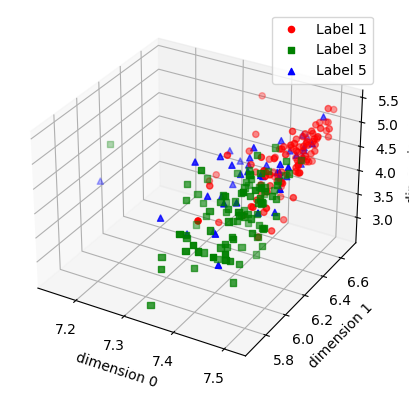

In [22]:
# Create a 3D plot, where the dimensions are the dimensions of the holes

x1, y1, z1 = extract_coordinates(persistence_entropy1)
x3, y3, z3 = extract_coordinates(persistence_entropy3)
x5, y5, z5 = extract_coordinates(persistence_entropy5)
x7, y7, z7 = extract_coordinates(persistence_entropy7)



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot keys from each dictionary with different colors
ax.scatter(x1, y1, z1, c='r', marker='o', label='Label 1')
ax.scatter(x3, y3, z3, c='g', marker='s', label='Label 3')
ax.scatter(x5, y5, z5, c='b', marker='^', label='Label 5')
#ax.scatter(x7, y7, z7, c='y', marker='^', label='Label 7')


ax.set_xlabel('dimension 0')
ax.set_ylabel('dimension 1')
ax.set_zlabel('dimension 2')

ax.legend()

plt.show()

### Plotting Amplitude

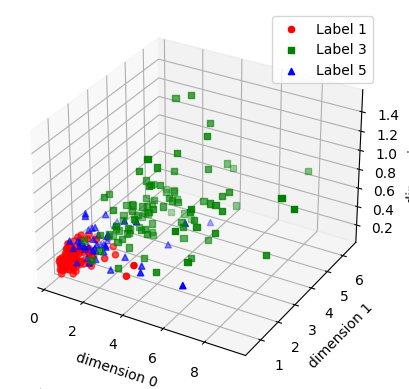

In [23]:
# Create a 3D plot, where the dimensions are the dimensions of the holes

x1, y1, z1 = extract_coordinates(amplitude1)
x3, y3, z3 = extract_coordinates(amplitude3)
x5, y5, z5 = extract_coordinates(amplitude5)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot keys from each dictionary with different colors
ax.scatter(x1, y1, z1, c='r', marker='o', label='Label 1')
ax.scatter(x3, y3, z3, c='g', marker='s', label='Label 3')
ax.scatter(x5, y5, z5, c='b', marker='^', label='Label 5')

ax.set_xlabel('dimension 0')
ax.set_ylabel('dimension 1')
ax.set_zlabel('dimension 2')

ax.legend()

plt.show()

### Plotting the Number of Points

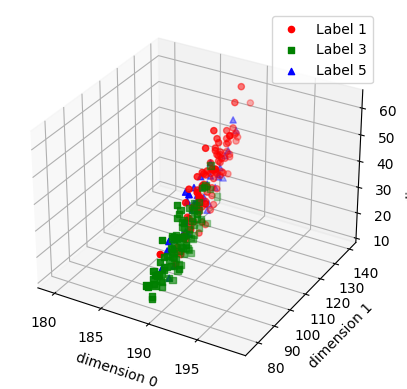

In [24]:
# Create a 3D plot, where the dimensions are the dimensions of the holes

x1, y1, z1 = extract_coordinates(no_points1)
x3, y3, z3 = extract_coordinates(no_points3)
x5, y5, z5 = extract_coordinates(no_points5)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot keys from each dictionary with different colors
ax.scatter(x1, y1, z1, c='r', marker='o', label='Label 1')
ax.scatter(x3, y3, z3, c='g', marker='s', label='Label 3')
ax.scatter(x5, y5, z5, c='b', marker='^', label='Label 5')

ax.set_xlabel('dimension 0')
ax.set_ylabel('dimension 1')
ax.set_zlabel('dimension 2')

ax.legend()

plt.show()

### Complex Polynomials

## Analyzing the Distribution of Persistence Diagrams

For the next analyses, we will need to compare persistence diagrams (pairwise). Giotto TDA needs all diagrams to have the same length for this (to have the same amount of holes). We will therefore cut off some "noise" (holes with low persistence) such that all persistence diagrams have the same length.

In [25]:
def cut_diagrams(flattened_diagrams, no_holes_per_dimension):
    # no_holes_per_dimension is a list indicating how many holes for each dimension there should be left
    shortened_diagrams = []

    for diagram in flattened_diagrams: # There are no_segments many diagrams per label at max (as chosen in the beginning)
        most_significant_holes_per_diagram = []
        holes = {}
        for hole_dimension, number_of_holes in zip(range(3), no_holes_per_dimension):
            # the third entry of each point (hole) in a diagram indicates its dimensionality
            holes[hole_dimension] = diagram[np.where(diagram[:, 2] == hole_dimension)[0]]

            if number_of_holes > len(holes[hole_dimension]):
                print("Watch out! There is a diagram shorter than the shortened diagrams")
                print("It has " + str(len(holes[hole_dimension])) + " holes of dimension " + str(hole_dimension))

            # The first and second entries of each hole indicate its birth and death, the difference is the persistence
            large_persistence_indices = np.argsort(holes[hole_dimension][:, 0] - holes[hole_dimension][:, 1])[-number_of_holes:]
            
            # For each dimension, getting the holes with the above indices (the holes with the largest persistence)
            significant_holes_with_hole_dimension = holes[hole_dimension][large_persistence_indices, :]
            most_significant_holes_per_diagram.extend(significant_holes_with_hole_dimension)

        shortened_diagrams.append(most_significant_holes_per_diagram)

    return shortened_diagrams

In [26]:
# Label 1

no_holes_per_dimension1 = [110, 80, 15]

flattened_diagrams = []
for key, value in diagrams1.items():
    flattened_diagrams.append(value[0])

shortened_diagrams1 = cut_diagrams(flattened_diagrams, no_holes_per_dimension1)

In [27]:
# Label 3

no_holes_per_dimension3 = [100, 68, 7]

flattened_diagrams = []
for key, value in diagrams3.items():
    flattened_diagrams.append(value[0])

shortened_diagrams3 = cut_diagrams(flattened_diagrams, no_holes_per_dimension3)

In [28]:
# Label 5

no_holes_per_dimension5 = [120, 60, 12] 

flattened_diagrams = []
for key, value in diagrams5.items():
    flattened_diagrams.append(value[0])

shortened_diagrams5 = cut_diagrams(flattened_diagrams, no_holes_per_dimension5)

In [29]:
# Label 7

# One "outlier" diagram only has one 2-dimensional hole
# Later, such outliers should be deleted before computing the pairwise distances
# between all diagrams, because eventually all diagrams should be shortened to the
# length of the shortest diagram

no_holes_per_dimension7 = [50, 9, 1] 


flattened_diagrams = []
for key, value in diagrams7.items():
    flattened_diagrams.append(value[0])

shortened_diagrams7 = cut_diagrams(flattened_diagrams, no_holes_per_dimension7)

### Wasserstein Distances and Wasserstein Barycenter

The Wasserstein Barycenter is the most representative persistence diagram in a set of diagrams, so the one with the lowest overall (Wasserstein) distance to all other diagrams.

Label 1

In [ ]:
# Finding the most representative diagram for label 1

# First, compute the pairwise Wasserstein distances
wasserstein_distance1 = PairwiseDistance(metric="wasserstein").fit_transform(shortened_diagrams1)

# For each hole, calculate the sum of distances to all other holes
sum_distances = [sum(dist) for dist in wasserstein_distance1]
most_representative_index = np.argmin(sum_distances)

# Find the index of the point with the smallest Wasserstein distances (sum)
keys_of_diagrams1 = list(y_embedded1.keys())

most_representative_key = keys_of_diagrams1[most_representative_index]

# Wasserstein Barycenter for label 1
representative_diagram1 = persistence.fit_transform_plot(y_embedded1[most_representative_key])

In [ ]:
# Create an histogram of the Wasserstein distance of all diagrams to the Wasserstein barycenter
all_distances_to_barycenter1 = []

shortened_barycenter1 = cut_diagrams([representative_diagram1[0]], no_holes_per_dimension1)

for diagram in shortened_diagrams1:
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter1[0]])
    all_distances_to_barycenter1.append(max(dist[0]))


mean1 = statistics.mean(all_distances_to_barycenter1)
mean = "{:.9f}".format(mean1)

plt.hist(all_distances_to_barycenter1, bins=20, edgecolor='black', alpha=0.7)

plt.xlabel('Wasserstein Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Wasserstein Distances')

plt.show()

print("")
print("The mean Distance to Wasserstein barycenter for label 1: " + str(mean))

Label 3

In [ ]:
# Compute the pairwise Wasserstein distances also for label 3
wasserstein_distance3 = PairwiseDistance(metric="wasserstein").fit_transform(shortened_diagrams3)

# For each hole, calculate the sum of distances to all other holes
sum_distances = [sum(dist) for dist in wasserstein_distance3]

# Find the index of the point with the smallest Wasserstein distances (sum)
most_representative_index = np.argmin(sum_distances)

keys_of_diagrams3 = list(y_embedded3.keys())

most_representative_key = keys_of_diagrams3[most_representative_index]

# Wasserstein Barycenter for label 3
representative_diagram3 = persistence.fit_transform_plot(y_embedded3[most_representative_key])

In [ ]:
# Create an histogram of the Wasserstein distance of all diagrams to the Wasserstein barycenter
all_distances_to_barycenter3 = []

shortened_barycenter3 = cut_diagrams([representative_diagram3[0]], no_holes_per_dimension3)

for diagram in shortened_diagrams3:
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter3[0]])
    all_distances_to_barycenter3.append(max(dist[0]))


mean3 = statistics.mean(all_distances_to_barycenter3)
mean = "{:.9f}".format(mean3)

plt.hist(all_distances_to_barycenter3, bins=20, edgecolor='black', alpha=0.7)

plt.xlabel('Wasserstein Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Wasserstein Distances')

plt.show()

print("")
print("The mean Distance to Wasserstein barycenter for label 3: " + str(mean))

Label 5

In [ ]:
# Compute the pairwise Wasserstein distances for label 4
wasserstein_distance5 = PairwiseDistance(metric="wasserstein").fit_transform(shortened_diagrams5)

# For each hole, calculate the sum of distances to all other holes
sum_distances = [sum(dist) for dist in wasserstein_distance5]

most_representative_index = np.argmin(sum_distances)


keys_of_diagrams5 = list(y_embedded5.keys())

most_representative_key = keys_of_diagrams5[most_representative_index]

# Wasserstein Barycenter for label 5
representative_diagram5 = persistence.fit_transform_plot(y_embedded5[most_representative_key])

In [ ]:
# Create an histogram of the Wasserstein distance of all diagrams to the Wasserstein barycenter
all_distances_to_barycenter5 = []

shortened_barycenter5 = cut_diagrams([representative_diagram5[0]], no_holes_per_dimension5)

for diagram in shortened_diagrams5:
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter5[0]])
    all_distances_to_barycenter5.append(max(dist[0]))


mean5 = statistics.mean(all_distances_to_barycenter1)
mean = "{:.9f}".format(mean5)

plt.hist(all_distances_to_barycenter5, bins=20, edgecolor='black', alpha=0.7)

plt.xlabel('Wasserstein Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Wasserstein Distances')

plt.show()

print("")
print("The mean Distance to Wasserstein barycenter for label 5: " + str(mean))

#### Results

The Wasserstein Distance distributions of label 3 and 5 are broader than the one of label 5, and the average distances are twice as large, so the diagrams are more diverse (there is more variability).

#### Computing Average Across-Label Distance for new Data

Trying to assign new label 1 segments.

In [ ]:
# Taking the next segments in data

for label in list(set(labels)): 
    indices = [index for index, value in enumerate(labels) if value == label][no_segments:no_segments+80]
    indices_dict[label] = indices

# Point cloud embeddings
new_y_embedded1 = {} 

# Persistence diagrams
new_diagrams1 = {}

# Loop through the first segments with label '1'
for label_idx in indices_dict[1]:
    new_y_embedded1[label_idx] = embedder_periodic.fit_transform(eeg_segments[label_idx])[None, :, :]
    new_diagrams1[label_idx] = persistence.fit_transform(new_y_embedded1[label_idx])

no_holes_per_dimension1 = [120, 60, 11] 

flattened_diagrams = []
for key, value in new_diagrams1.items():
    flattened_diagrams.append(value[0])

new_shortened_diagrams1 = cut_diagrams(flattened_diagrams, no_holes_per_dimension1)

In [ ]:
all_distances_to_barycenter1 = []
all_distances_to_barycenter3 = []
all_distances_to_barycenter5 = []

shortened_barycenter1 = cut_diagrams([representative_diagram1[0]], no_holes_per_dimension1)
shortened_barycenter3 = cut_diagrams([representative_diagram3[0]], no_holes_per_dimension1)
shortened_barycenter5 = cut_diagrams([representative_diagram5[0]], no_holes_per_dimension1)

accurately_assigned = 0

for diagram in new_shortened_diagrams1:
    dist_to_1 = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter1[0]])
    dist_to_3 = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter3[0]])
    dist_to_5 = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter5[0]])

    scaled_dist_to_1 = max(dist_to_1[0])/mean1
    scaled_dist_to_3 = max(dist_to_3[0])/mean3
    scaled_dist_to_5 = max(dist_to_5[0])/mean5

    if scaled_dist_to_1 == min(scaled_dist_to_1, scaled_dist_to_3, scaled_dist_to_5):
        accurately_assigned += 1

    all_distances_to_barycenter1.append(scaled_dist_to_1)
    all_distances_to_barycenter3.append(scaled_dist_to_3)
    all_distances_to_barycenter5.append(scaled_dist_to_5)


mean = statistics.mean(all_distances_to_barycenter1)
absolute_mean = mean*mean1
mean = "{:.9f}".format(mean)
print("Mean scaled distance of new label 1 diagrams to label 1 Wasserstein barycenter: " + str(mean))


print("")
mean = statistics.mean(all_distances_to_barycenter3)
absolute_mean = mean*mean3
mean = "{:.9f}".format(mean)
print("Mean scaled distance of new label 1 diagrams to label 3 Wasserstein barycenter: " + str(mean))


print("")
mean = statistics.mean(all_distances_to_barycenter5)
absolute_mean = mean*mean5
mean = "{:.9f}".format(mean)
print("Mean scaled distance of new label 1 diagrams to label 5 Wasserstein barycenter: " + str(mean))

print("")
print("Overall accuracy: " + str(accurately_assigned/len(new_shortened_diagrams1)))

Doing the same for label 3.

In [ ]:
# Taking the next segments in data
for label in list(set(labels)): 
    indices = [index for index, value in enumerate(labels) if value == label][no_segments:no_segments+80]
    indices_dict[label] = indices

# Point cloud embeddings
new_y_embedded3 = {} 

# Persistence diagrams
new_diagrams3 = {}

# Loop through the first segments with label '3'
for label_idx in indices_dict[3]:
    new_y_embedded3[label_idx] = embedder_periodic.fit_transform(eeg_segments[label_idx])[None, :, :]
    new_diagrams3[label_idx] = persistence.fit_transform(new_y_embedded3[label_idx])


no_holes_per_dimension3 = [120, 50, 9] 

flattened_diagrams = []
for key, value in new_diagrams3.items():
    flattened_diagrams.append(value[0])

new_shortened_diagrams3 = cut_diagrams(flattened_diagrams, no_holes_per_dimension3)

In [ ]:
all_distances_to_barycenter1 = []
all_distances_to_barycenter3 = []
all_distances_to_barycenter5 = []

shortened_barycenter1 = cut_diagrams([representative_diagram1[0]], no_holes_per_dimension3)
shortened_barycenter3 = cut_diagrams([representative_diagram3[0]], no_holes_per_dimension3)
shortened_barycenter5 = cut_diagrams([representative_diagram5[0]], no_holes_per_dimension3)


accurately_assigned = 0

for diagram in new_shortened_diagrams3:
    dist_to_1 = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter1[0]])
    dist_to_3 = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter3[0]])
    dist_to_5 = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter5[0]])

    scaled_dist_to_1 = max(dist_to_1[0])/mean1
    scaled_dist_to_3 = max(dist_to_3[0])/mean3
    scaled_dist_to_5 = max(dist_to_5[0])/mean5

    if scaled_dist_to_3 == min(scaled_dist_to_1, scaled_dist_to_3, scaled_dist_to_5):
        accurately_assigned += 1

    all_distances_to_barycenter1.append(scaled_dist_to_1)
    all_distances_to_barycenter3.append(scaled_dist_to_3)
    all_distances_to_barycenter5.append(scaled_dist_to_5)


mean = statistics.mean(all_distances_to_barycenter1)
absolute_mean = mean*mean1
mean = "{:.9f}".format(mean)
print("Mean scaled distance of new label 3 diagrams to label 1 Wasserstein barycenter: " + str(mean))


print("")
mean = statistics.mean(all_distances_to_barycenter3)
absolute_mean = mean*mean3
mean = "{:.9f}".format(mean)
print("Mean scaled distance of new label 3 diagrams to label 3 Wasserstein barycenter: " + str(mean))


print("")
mean = statistics.mean(all_distances_to_barycenter5)
absolute_mean = mean*mean5
mean = "{:.9f}".format(mean)
print("Mean scaled distance of new label 3 diagrams to label 5 Wasserstein barycenter: " + str(mean))

print("")
print("Overall accuracy: " + str(accurately_assigned/len(new_shortened_diagrams3)))

### HeatKernel

In a way, the Heat Kernel shows an "average distribution" of the persistence diagrams for each label, seperated per hole dimensionality.

Label 1

In [ ]:
HK = HeatKernel(sigma=0.00003, n_bins=100)

heatkernel = HK.fit_transform(shortened_diagrams1)

HK.plot(heatkernel, homology_dimension_idx=0)

In [ ]:
np.mean(heatkernel)

In [ ]:
HK.plot(heatkernel, homology_dimension_idx=1)

In [ ]:
HK.plot(heatkernel, homology_dimension_idx=2)

Label 3

In [ ]:
heatkernel = HK.fit_transform(shortened_diagrams3)

HK.plot(heatkernel, homology_dimension_idx=0)

In [ ]:
np.mean(heatkernel)

Higher "intensity" than above

In [ ]:
heatkernel = HK.fit_transform([shortened_diagrams3[0]])

In [ ]:
len(heatkernel[0][0]) # 100 bins

Return dimensions: (n_samples, n_homology_dimensions, n_bins, n_bins)

In [ ]:
HK.plot(heatkernel, homology_dimension_idx=1)

In [ ]:
np.mean(heatkernel)

In [ ]:
HK.plot(heatkernel, homology_dimension_idx=2)

Label 5

In [ ]:
heatkernel = HK.fit_transform(shortened_diagrams5)

HK.plot(heatkernel, homology_dimension_idx=0)

In [ ]:
HK.plot(heatkernel, homology_dimension_idx=1)

In [ ]:
HK.plot(heatkernel, homology_dimension_idx=2)

### Persistance Landscape

In [ ]:
PL = PersistenceLandscape()

Label 1

Persistence landscapes map persistence diagrams into a function space, which may often be taken to be a Banach space or even a Hilbert space

In [ ]:
persistence_landscape = PL.fit_transform(shortened_diagrams1)

PL.plot(persistence_landscape)

Label 3

In [ ]:
persistence_landscape = PL.fit_transform(shortened_diagrams3)

PL.plot(persistence_landscape)

Label 5

In [ ]:
persistence_landscape = PL.fit_transform(shortened_diagrams5)

PL.plot(persistence_landscape)

## Silhouette

I calculated an overall silhouette for all labels together.

In [ ]:
diagrams_with_significant_points_only = []

diagrams_with_significant_points_only.extend(shortened_diagrams1)
diagrams_with_significant_points_only.extend(shortened_diagrams3)

In [ ]:
SH = Silhouette()

silhouette = SH.fit_transform(diagrams_with_significant_points_only)

SH.plot(silhouette, homology_dimensions = [0])

In [ ]:
SH.plot(silhouette, homology_dimensions = [1])

In [ ]:
SH.plot(silhouette, homology_dimensions = [2])

## Scatter plots

This is mainly for fun. It'is an example scatter plot for showing dependencies between the number of holes of different dimensions in a persistence diagram. 

In [ ]:
plt.scatter(z1, y1)
plt.show()

In [ ]:
plt.scatter(z3, y3)
plt.show()

The numbers of tunnels and voids are positively correlated.

# Global Approach

In [ ]:
# Merge Together all segments with the same label
grouped_segments = {label: [] for label in {1, 2, 3, 4, 5, 7}}

# Group segments based on labels
for segment, label in zip(eeg_segments, labels):
    grouped_segments[label].extend(segment)

# Create merged lists for each label
merged_lists = {label: merged_segment for label, merged_segment in grouped_segments.items()}

## PCA Point Cloud

In [ ]:
data = []
data.extend(merged_lists[1])
data.extend(merged_lists[3])
data.extend(merged_lists[4])

global_y_embedded = embedder_periodic.fit_transform(data[:10000])

# Apply dimensionality PCA to project down to 3-dimensions for visualisation:
pca = PCA(n_components=3)
y_embedded_pca = pca.fit_transform(global_y_embedded)
plot_point_cloud(y_embedded_pca)

There are no clusters or similar visible here

In [ ]:
global_y_embedded1 = embedder_periodic.fit_transform(merged_lists[1][:10000])
global_y_embedded3 = embedder_periodic.fit_transform(merged_lists[3][:10000])
global_y_embedded5 = embedder_periodic.fit_transform(merged_lists[5][:10000])


## Persistence Diagrams

Label 1

In [ ]:
# Persistance Diagram for the whole data labelled with 1 (or rather first 10,000 entries)
global_diagram1 = persistence.fit_transform_plot(global_y_embedded1[None, :, :])
global_persistence_entropy1 = PE.fit_transform(global_diagram1)
global_amplitude1  = AM.fit_transform(global_diagram1)
global_no_points1  = NP.fit_transform(global_diagram1)
global_complex_polynomial1  = CP.fit_transform(global_diagram1)

print("Features for dimensions 0, 1, 2:")
print("")
print("Persistence Entropies: " + str(global_persistence_entropy1))
print("Amplitudes: " + str(global_amplitude1))
print("Numbers of Points: " + str(global_no_points1))
#print("Complex Polynomials: " + str(global_complex_polynomial1))

Label 3

In [ ]:
# Persistance Diagram for the whole data labelled with 3 (or rather first 10,000 entries)
y_embedded = global_y_embedded3[None, :, :]

global_diagram3 = persistence.fit_transform_plot(y_embedded)

global_persistence_entropy3 = PE.fit_transform(global_diagram3)
global_amplitude3  = AM.fit_transform(global_diagram3)
global_no_points3  = NP.fit_transform(global_diagram3)
global_complex_polynomial3  = CP.fit_transform(global_diagram3)

print("Features for dimensions 0, 1, 2:")
print("")
print("Persistence Entropies: " + str(global_persistence_entropy3))
print("Amplitudes: " + str(global_amplitude3))
print("Numbers of Points: " + str(global_no_points3))
#print("Complex Polynomials: " + str(global_complex_polynomial3))

In [ ]:
# Persistance Diagram for the whole data labelled with 4 (or rather first 10,000 entries)
y_embedded = global_y_embedded5[None, :, :]

global_diagram4 = persistence.fit_transform_plot(y_embedded)

global_persistence_entropy4 = PE.fit_transform(global_diagram4)
global_amplitude4  = AM.fit_transform(global_diagram4)
global_no_points4  = NP.fit_transform(global_diagram4)
global_complex_polynomial4  = CP.fit_transform(global_diagram4)

print("Features for dimensions 0, 1, 2:")
print("")
print("Persistence Entropies: " + str(global_persistence_entropy4))
print("Amplitudes: " + str(global_amplitude4))
print("Numbers of Points: " + str(global_no_points4))
#print("Complex Polynomials: " + str(global_complex_polynomial3))

#### Analysis 
- They visually look different, but also have different scales
- The amplitude (especially of connectivities) for label 1 is much lower than for the other two labels
-  Label 3 also has relatively few voids, label 1 has the most voids (which is also visible in the "Number of Points" plot in the Local Analyis)

## Persistence Landscape

In [ ]:
PL = PersistenceLandscape()


In [ ]:
# Persistence landscape for label 1

persistence_landscape = PL.fit_transform(global_diagram1)

PL.plot(persistence_landscape)

In [ ]:
# Persistence landscape for label 3

persistence_landscape = PL.fit_transform(global_diagram3)

PL.plot(persistence_landscape)

In [ ]:
# Persistence landscape for label 4

persistence_landscape = PL.fit_transform(global_diagram4)

PL.plot(persistence_landscape)

# Experiments

## Experiments with PCA & ICA

Comparing the three approaches for the noisy level 4

- Using an Embedding dimension of 5 and reducing the space to 3D with PCA
- Using an Embedding dimension of 5 and reducing the space to 3D with ICA
- Using an Embedding dimension of 3 directly

In [ ]:
# Without PCA
embedding_dimension= 3
embedding_time_delay = 25
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

y_embedded_without_pca = embedder_periodic.fit_transform(merged_lists[4][:10000])

plot_point_cloud(y_embedded_without_pca)

In [ ]:
# PCA

embedding_dimension= 5 # dimension 7 instead of 5
embedding_time_delay = 25
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

y_embedded = embedder_periodic.fit_transform(merged_lists[4][:10000])

pca = PCA(n_components=3)
y_embedded_pca = pca.fit_transform(y_embedded)
plot_point_cloud(y_embedded_pca)

In [ ]:
# ICA

embedding_dimension= 5 # dimension 7 instead of 5
embedding_time_delay = 25
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

y_embedded = embedder_periodic.fit_transform(merged_lists[4][:10000])

pca = FastICA(n_components=3)
y_embedded_ica = pca.fit_transform(y_embedded)
plot_point_cloud(y_embedded_ica)

In [ ]:
def max_distance(points):
  n_points = points.shape[0]
  max_distance = 0
  for i in range(n_points):
    for j in range(i + 1, n_points):
      distance = np.linalg.norm(points[i] - points[j])
      if distance > max_distance:
        max_distance = distance

  return max_distance

print(max_distance(y_embedded_without_pca))
print(max_distance(y_embedded_pca))
print(max_distance(y_embedded_ica))

In the PCA approach, the point cloud looks "rounder", so there is not one primary component. They have a similar amount of outliers, but the outliers in the PCA approach are more equally distributed. What happens if I plot the persistence diagram?

In [ ]:
# Persistance Diagram for approach without PCA
y_embedded = y_embedded_without_pca[None, :, :]

diagram_without_pca = persistence.fit_transform_plot(y_embedded)

In [ ]:
# Persistance Diagram for approach with PCA
y_embedded = y_embedded_pca[None, :, :]

diagram_with_pca = persistence.fit_transform_plot(y_embedded)

In [ ]:
# Persistance Diagram for approach with PCA
y_embedded = y_embedded_ica[None, :, :]

diagram_with_ica = persistence.fit_transform_plot(y_embedded)

Overall, PCA and ICA probably do not add much value here.

## Visualizing Vietoris-Rips complexes

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# Generate example point embedding
# Define the radius for Vietoris-Rips complex
radius = 0.38e-4 # ideal value for 0 dimensional holes
radius = 0.65e-4 # ideal value for 1 dimensional holes
radius = 1.1e-4 # ideal value for 2 dimensional holes

points = global_y_embedded
num_points = len(points)
# Calculate pairwise distances between points
distances = euclidean_distances(points)

# Create a NetworkX graph for the Vietoris-Rips complex
G = nx.Graph()

# Add vertices (nodes) to the graph
for i in range(num_points):
    G.add_node(i, pos=(points[i, 0], points[i, 1]))

# Add edges based on the distance matrix and radius
for i in range(num_points):
    for j in range(i + 1, num_points):
        if distances[i, j] <= radius:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=8)
plt.title("Vietoris-Rips Complex Visualization")
plt.show()


## Experimental Code

In [ ]:
# If I add the labels to the DataFrame data as a column target, this is a fancy way of
# Retrieving different datasets for each label

data = {
    "x": [1, 2, 3, 4, 5, 6],
    "y": [10, 20, 30, 40, 50, 60],
    "z": [100, 200, 300, 400, 500, 600],
    "target": ["A", "B", "A", "C", "B", "C"]
}
df = pd.DataFrame(data)

# Calculate point_clouds
point_clouds = np.asarray(
    [
        df.query("target == @shape")[["x", "y", "z"]].values
        for shape in df["target"].unique()
    ]
)

# Next steps

- Upload code on Google Colab
- Remove outliers before (Artifacts Removal)
- Remove noise from persistance diagrams (holes with very low persistence)
- Other preprocessing (PCA? Wavelet Decomposition? "Downsampling")?
- Bandpass filtering
- Later use filtering on persistence diagrams (gtda.diagrams.Filtering() )
- Scaling (Did not immediately work on Timeseries data)?
- What can I do with the CWTs?
- Look dissimilarity matrix again (Wasserstein distances)